In [1]:
#Needs proofreading

# Region DE isoform hidden by gene

In [2]:
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import scanpy as sc
from scipy.stats import ks_2samp, ttest_ind
import ast
from scipy.sparse import csr_matrix
import warnings
warnings.filterwarnings('ignore')


import sys
sys.path.append('../../../BYVSTZP_2020/dexpress')
from dexpress import dexpress, utils, plot

#sys.path.append('../../../BYVSTZP_2020/trackfig')
#from trackfig.utils import get_notebook_name
#from trackfig.trackfig import trackfig 

#TRACKFIG = "../../../BYVSTZP_2020/trackfig.txt"
#NB = get_notebook_name()

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

/home/nmarkari/.local/lib/python3.6/site-packages/numba/core/errors.py:154: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


In [3]:
subclass_cmap = pd.read_csv('../metadata_files/CTX_Hip_anno_SSv4.csv', index_col='subclass_label',usecols=['subclass_label','subclass_color'])
subclass_cmap = subclass_cmap.drop_duplicates()
subclass_cmap = subclass_cmap.subclass_color.apply(lambda x: mcolors.to_rgb(x) )
subclass_cmap = subclass_cmap.to_dict()

In [4]:
cluster_cmap = {
"Astro": (0.38823529411764707, 0.4745098039215686,  0.2235294117647059 ),  # 637939,
"Endo" : (0.5490196078431373,  0.6352941176470588,  0.3215686274509804 ),  # 8ca252,
"SMC"  : (0.7098039215686275,  0.8117647058823529,  0.4196078431372549 ),  # b5cf6b,
"VLMC" : (0.807843137254902,   0.8588235294117647,  0.611764705882353  ),  # cedb9c,
"Low Quality" : (0,0,0),
"L2/3 IT" : (0.9921568627450981,  0.6823529411764706,  0.4196078431372549  ),  # fdae6b
"L5 PT" : (0.9921568627450981,  0.8156862745098039,  0.6352941176470588  ),  # fdd0a2
"L5 IT" : (0.5176470588235295,  0.23529411764705882, 0.2235294117647059 ),  # 843c39
"L5/6 NP": "#D43F3A",
"L6 CT" : (0.8392156862745098,  0.3803921568627451,  0.4196078431372549 ),  # d6616b
"L6 IT" : (0.9058823529411765,  0.5882352941176471,  0.611764705882353  ),  # e7969c
"L6b" : (1.0,                 0.4980392156862745,  0.054901960784313725),  # ff7f0e
"L6 IT Car3" : (1.0,                 0.7333333333333333,  0.47058823529411764 ),  # ffbb78
"Lamp5" : (0.19215686274509805, 0.5098039215686274,  0.7411764705882353  ),  # 3182bd # blues
"Sncg" : (0.4196078431372549,  0.6823529411764706,  0.8392156862745098  ),  # 6baed6
"Vip" : (0.6196078431372549,  0.792156862745098,   0.8823529411764706  ),  # 9ecae1
"Sst" : (0.7764705882352941,  0.8588235294117647,  0.9372549019607843  ),  # c6dbef
"Pvalb":(0.7372549019607844,  0.7411764705882353,  0.8627450980392157  ),  # bcbddc
}

In [5]:
gene = anndata.read_h5ad("../../data/notebook/revision/gene.h5ad")
isoform = anndata.read_h5ad("../../data/notebook/revision/isoform.h5ad")

In [6]:
isoform = isoform[:,isoform.var.sort_values("gene_id").index]
gene = gene[:,gene.var.sort_values("gene_id").index]

In [7]:
isoform = isoform[isoform.obs.eval("subclass_label != 'L5 IT'").values]
gene = gene[gene.obs.eval("subclass_label != 'L5 IT'").values]

In [8]:
print(isoform.shape)
print(gene.shape)

(18175, 81527)
(18175, 26154)


In [9]:
mask = np.logical_or(gene.obs.class_label == "Glutamatergic", gene.obs.class_label == "GABAergic")

c_gene = gene[mask]
c_isoform = isoform[mask]

In [10]:
%%time
mat           = c_gene.layers["log1p"].todense()
components    = c_gene.obs.cell_id.values
features      = c_gene.var.gene_name.values
assignments   = c_gene.obs.region_label.values

unique = np.unique(assignments)
nan_cutoff = 0.9 # of elements in cluster
corr_method = "bonferroni"


p_raw, stat, es, nfeat = dexpress.dexpress(mat, components, features, assignments, nan_cutoff=nan_cutoff)
p_raw = p_raw/2
p_corr = utils.correct_pval(p_raw, nfeat, corr_method)

s = stat

markers_gene = dexpress.make_table(assignments, features, p_raw, p_corr, es)

# convert the 0 pvalues to the smallest possible float
markers_gene["p_corr"][markers_gene.eval("p_corr == 0").values] = sys.float_info.min
markers_gene = markers_gene.query("es > 0")

26-Jul-21 20:51:12 - 1 of 9 assignments: AI
26-Jul-21 20:51:15 - 2 of 9 assignments: ENTl
26-Jul-21 20:51:17 - 3 of 9 assignments: ENTm
26-Jul-21 20:51:19 - 4 of 9 assignments: HIP
26-Jul-21 20:51:22 - 5 of 9 assignments: ORB
26-Jul-21 20:51:24 - 6 of 9 assignments: PL-ILA
26-Jul-21 20:51:26 - 7 of 9 assignments: RSP
26-Jul-21 20:51:27 - 8 of 9 assignments: SUB-ProS
26-Jul-21 20:51:29 - 9 of 9 assignments: TEa-PERI-ECT


CPU times: user 14.4 s, sys: 12.4 s, total: 26.9 s
Wall time: 26.9 s


In [11]:
%%time
mat         = c_isoform.layers["log1p"].todense() # expects dense matrix
components  = c_isoform.obs.cell_id.values
features    = c_isoform.var.transcript_name.values
assignments = c_isoform.obs.region_label.values

unique = np.unique(assignments)
nan_cutoff = 0.9 # of elements in cluster
corr_method = "bonferroni"


p_raw, stat, es, nfeat = dexpress.dexpress(mat, components, features, assignments, nan_cutoff=nan_cutoff)
p_raw = p_raw/2
p_corr = dexpress.correct_pval(p_raw, nfeat, corr_method)

s = stat

markers_isoform = dexpress.make_table(assignments, features, p_raw, p_corr, es)

# convert the 0 pvalues to the smallest possible float
markers_isoform["p_corr"][markers_isoform.eval("p_corr == 0").values] = sys.float_info.min
markers_isoform = markers_isoform.query("es > 0")

26-Jul-21 20:51:46 - 1 of 9 assignments: AI
26-Jul-21 20:52:05 - 2 of 9 assignments: ENTl
26-Jul-21 20:52:11 - 3 of 9 assignments: ENTm
26-Jul-21 20:52:16 - 4 of 9 assignments: HIP
26-Jul-21 20:52:22 - 5 of 9 assignments: ORB
26-Jul-21 20:52:30 - 6 of 9 assignments: PL-ILA
26-Jul-21 20:52:36 - 7 of 9 assignments: RSP
26-Jul-21 20:52:41 - 8 of 9 assignments: SUB-ProS
26-Jul-21 20:52:46 - 9 of 9 assignments: TEa-PERI-ECT


CPU times: user 29.2 s, sys: 51.3 s, total: 1min 20s
Wall time: 1min 20s


# Want to make a mask to return the isoforms for which the isoform is differential but the gene is not

In [12]:
alpha =0.01
fc = 2

relevant_genes = markers_gene.p_corr < alpha

markers_gene["index_name"] = markers_gene["index"] + "_" + markers_gene.name.apply(lambda x: "".join(x.split("_")[:-1]))
markers_isoform["index_name"] = markers_isoform["index"] + "_" + markers_isoform.name.apply(lambda x: "-".join(x.split("-")[:-1]))

setdiff = np.setdiff1d(markers_isoform["index_name"].values, markers_gene[relevant_genes]["index_name"].values)

In [13]:
markers_isoform = markers_isoform[markers_isoform["index_name"].isin(setdiff)].sort_values(["es", "p_corr"])

markers_isoform = markers_isoform.query(f"p_corr < {alpha}")
markers_isoform.sort_values("es")[::-1][:20]

,index,name,p_raw,p_corr,es,index_name
188612,ENTm,Snap25-202_ENSMUST00000110098.4,4.02656e-202,9.63556e-199,1.26279,ENTm_Snap25
570392,RSP,7SK.188-201_ENSMUST00020183253.1,1.46331e-130,2.54908e-127,1.18606,RSP_7SK.188
551578,RSP,Morf4l1-204_ENSMUST00000187771.8,1.46801e-76,2.55728e-73,1.065,RSP_Morf4l1
433193,PL-ILA,Snap25-202_ENSMUST00000110098.4,8.33635e-145,2.35335e-141,1.03884,PL-ILA_Snap25
359738,ORB,Aldoa-203_ENSMUST00000106348.8,5.06343e-31,1.36308e-27,0.795954,ORB_Aldoa
99646,ENTl,Nrxn1-207_ENSMUST00000160844.10,4.1203e-90,1.28677e-86,0.737039,ENTl_Nrxn1
388524,ORB,Morf4l1-204_ENSMUST00000187771.8,4.71679e-30,1.26976e-26,0.701174,ORB_Morf4l1
375535,ORB,Ttc3-216_ENSMUST00000147046.8,1.9774e-63,5.32317e-60,0.688071,ORB_Ttc3
469846,PL-ILA,Slc25a3-204_ENSMUST00000167455.8,3.08471e-29,8.70814e-26,0.606441,PL-ILA_Slc25a3
685846,TEa-PERI-ECT,Aldoa-203_ENSMUST00000106348.8,9.13699e-18,2.23217e-14,0.569552,TEa-PERI-ECT_Aldoa


In [14]:
#markers_gene[markers_gene.name.str.contains("Oxr1")]
markers_gene[markers_gene.name.str.contains("Snap25")]

,index,name,p_raw,p_corr,es,index_name
4967,AI,Snap25_ENSMUSG00000027273.14,1.97653e-59,6.46722e-56,0.205493,AI_Snap25
31121,ENTl,Snap25_ENSMUSG00000027273.14,1.11422e-07,0.000406245,0.057051,ENTl_Snap25
57275,ENTm,Snap25_ENSMUSG00000027273.14,7.18498e-05,0.199886,0.038592,ENTm_Snap25
109583,ORB,Snap25_ENSMUSG00000027273.14,1.97744e-112,6.06877e-109,0.295742,ORB_Snap25
135737,PL-ILA,Snap25_ENSMUSG00000027273.14,7.2333e-06,0.0228717,0.0518638,PL-ILA_Snap25
161891,RSP,Snap25_ENSMUSG00000027273.14,3.50093e-103,6.92135e-100,0.239022,RSP_Snap25
188045,SUB-ProS,Snap25_ENSMUSG00000027273.14,2.53929e-12,7.65088e-09,0.0647692,SUB-ProS_Snap25
214199,TEa-PERI-ECT,Snap25_ENSMUSG00000027273.14,0.123356,1,0.0142943,TEa-PERI-ECT_Snap25


In [15]:
isoform.var.transcript_name[isoform.var.transcript_name.str.contains("Snap25")]

Snap25-203_ENSMUST00000125486.2      Snap25-203_ENSMUST00000125486.2
Snap25-201_ENSMUST00000028727.11    Snap25-201_ENSMUST00000028727.11
Snap25-202_ENSMUST00000110098.4      Snap25-202_ENSMUST00000110098.4
Name: transcript_name, dtype: object

In [16]:
#specific_gene = "Oxr1_ENSMUSG00000022307"
#specific_isoform = "Oxr1-204_ENSMUST00000110297"

#specific_cluster = "Glutamatergic"
specific_gene = "Snap25_ENSMUSG00000027273.14"
specific_isoform = "Snap25-202_ENSMUST00000110098.4"

specific_region = "ENTm"

In [17]:
def violinplot(data, ax, **kwd): 
    xticklabels = kwd.get("xticklabels", [])
    xticks = kwd.get("xticks", [])
    selected = kwd.get("selected", None)
    color = kwd.get("color", "grey")
    
    if  len(xticks)==0: xticks = np.arange(len(data))+1;
    if  len(xticklabels)==0: xticklabels = np.arange(len(data))+1;
    assert(len(xticks) == len(xticklabels))
        
    violins = ax.violinplot(data, positions=xticks, showmeans=False, showmedians=False, showextrema=False)
    
    for vidx, v in enumerate(violins['bodies']):
        v.set_facecolor(color)
        v.set_edgecolor('black')
        v.set_alpha(1)
        if selected == vidx:
            v.set_facecolor("#D43F3A")

            
    
    for didx, d in enumerate(data):
        x = xticks[didx]
        xx = np.random.normal(x, 0.04, size=len(d))
        
        # actual points
        ax.scatter(xx, d, s = 5, color="white", edgecolor="black", linewidth=1)
        
        # mean and error bars
        mean = np.mean(d)
        stdev = np.sqrt(np.var(d))
        ax.scatter(x, mean, color="lightgrey", edgecolor="black", linewidth=1, zorder=10)    
        ax.vlines(x, mean - stdev, mean+stdev, color='lightgrey', linestyle='-', lw=2, zorder=9)
        
    ax.set(**{"xticks": xticks, "xticklabels":xticklabels})
    
    return ax


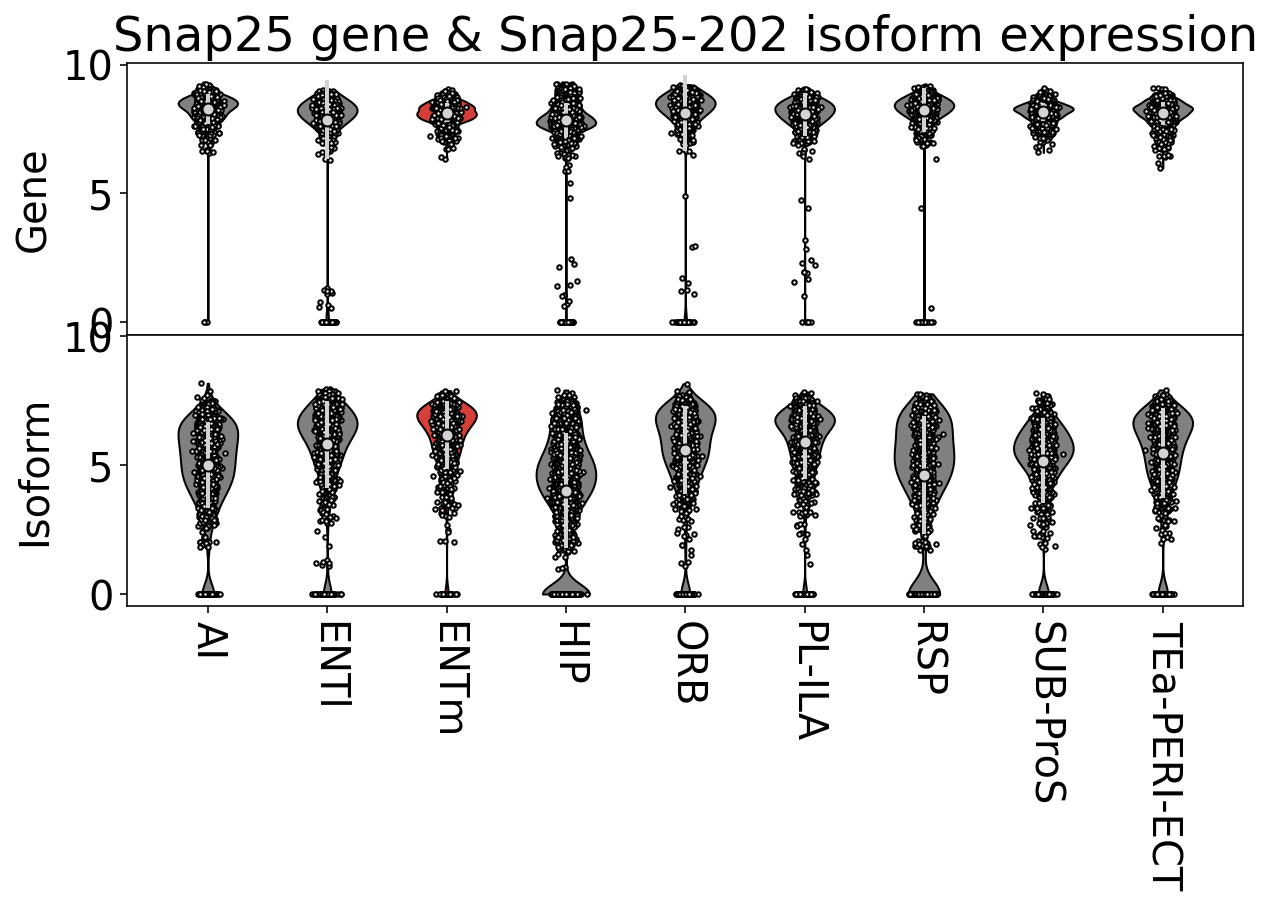

In [28]:
fig, ax = plt.subplots(figsize=(10,5), nrows=2, sharex=True)
fig.subplots_adjust(hspace=0, wspace=0)

# Declare
unique = np.unique(gene.obs.region_label)
unique = np.delete(unique, np.where(unique=="Low Quality"))
unique = np.delete(unique, np.where(unique=="Non-Neuronal"))
labels = unique
lidx = np.arange(1, len(labels)+1)  # the label locations
midx = np.where(unique==specific_region)[0]#[0]
plt.xticks(rotation=270)
## Plot
# Gene
x = []
for c in unique:
    x.append(np.asarray(gene[gene.obs.region_label==c][:,gene.var.gene_name==specific_gene].layers["log1p"].todense()).reshape(-1).tolist())

violinplot(x, ax[0], selected=midx)

# Isoform
x = []
for c in unique:
    x.append(np.asarray(isoform[isoform.obs.region_label==c][:,isoform.var.transcript_name==specific_isoform].layers["log1p"].todense()).reshape(-1).tolist())

violinplot(x, ax[1], selected=midx, xticks=lidx, xticklabels=labels)
## Style
ax[0].set(**{
    "title":"{} gene & {} isoform expression".format(specific_gene.split("_")[0], specific_isoform.split("_")[0]),
    "ylabel":"Gene",
})


ymin, ymax = ax[0].get_ylim()
ax[1].set(**{
    "ylabel":"Isoform",
    "ylim": (ymin, ymax),
})

plt.savefig("../../figures/region_DE_violin.png", bbox_inches='tight',dpi=300)
plt.show()

In [19]:
gene.obs

,cell_id,cluster_id,cluster_label,subclass_id,subclass_label,region_label,class_label,cluster_color,class_id,cell_counts,percent_mito,n_genes,pass_count_filter,leiden,louvain
0,SM-GE5TN_S001_E1-50,345,345_CA1,1,CA1-ProS,HIP,Glutamatergic,#680DFF,1,286.215515,2.001043,11329,True,5,6
1,SM-GE5TN_S002_E1-50,362,362_DG,6,DG,HIP,Glutamatergic,#3447B9,1,295.613159,2.276559,8265,True,0,0
2,SM-GE5TN_S003_E1-50,333,333_CA1-ProS,1,CA1-ProS,HIP,Glutamatergic,#8274BF,1,275.008270,1.412877,10184,True,5,6
3,SM-GE5TN_S004_E1-50,330,330_CA1-ProS,1,CA1-ProS,HIP,Glutamatergic,#8883C0,1,312.885132,1.964671,10989,True,5,6
4,SM-GE5TN_S005_E1-50,337,337_CA1,1,CA1-ProS,HIP,Glutamatergic,#A68CFF,1,350.497681,1.713655,9950,True,5,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1690-1,SM-GE8ZJ_S302_E1-50,223,223_L6 IT CTX,23,L6 IT CTX,RSP,Glutamatergic,#7F833B,1,471.582245,3.387203,9588,True,12,3
1691-1,SM-GE8ZJ_S303_E1-50,166,166_L2/3 IT CTX,10,L2/3 IT CTX,RSP,Glutamatergic,#00FF34,1,493.948547,3.096424,10044,True,6,7
1692-1,SM-GE8ZJ_S304_E1-50,193,193_L4/5 IT CTX,16,L4/5 IT CTX,RSP,Glutamatergic,#58D2C1,1,563.157471,3.218479,9089,True,11,3
1693-1,SM-GE91P_S383_E1-50,168,168_L2/3 IT CTX,10,L2/3 IT CTX,RSP,Glutamatergic,#02F970,1,372.662445,3.144827,9743,True,6,7


In [20]:
#c = np.asarray(isoform[:, isoform.var.transcript_name==specific_isoform].layers["log1p"].todense()).reshape(-1)
isoform[:, isoform.var.transcript_name==specific_isoform]

View of AnnData object with n_obs × n_vars = 18175 × 1
    obs: 'cell_id', 'cluster_id', 'cluster_label', 'subclass_id', 'subclass_label', 'region_label', 'class_label', 'cluster_color', 'class_id', 'cell_counts', 'leiden', 'louvain'
    var: 'transcript_id', 'gene_id', 'gene_name', 'transcript_name', 'length', 'gene_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'leiden', 'louvain', 'neighbors'
    obsm: 'X_nca', 'X_nca_tsne', 'X_pca', 'X_pca_tsne'
    layers: 'log1p', 'norm', 'raw', 'scaled'
    obsp: 'connectivities', 'distances'

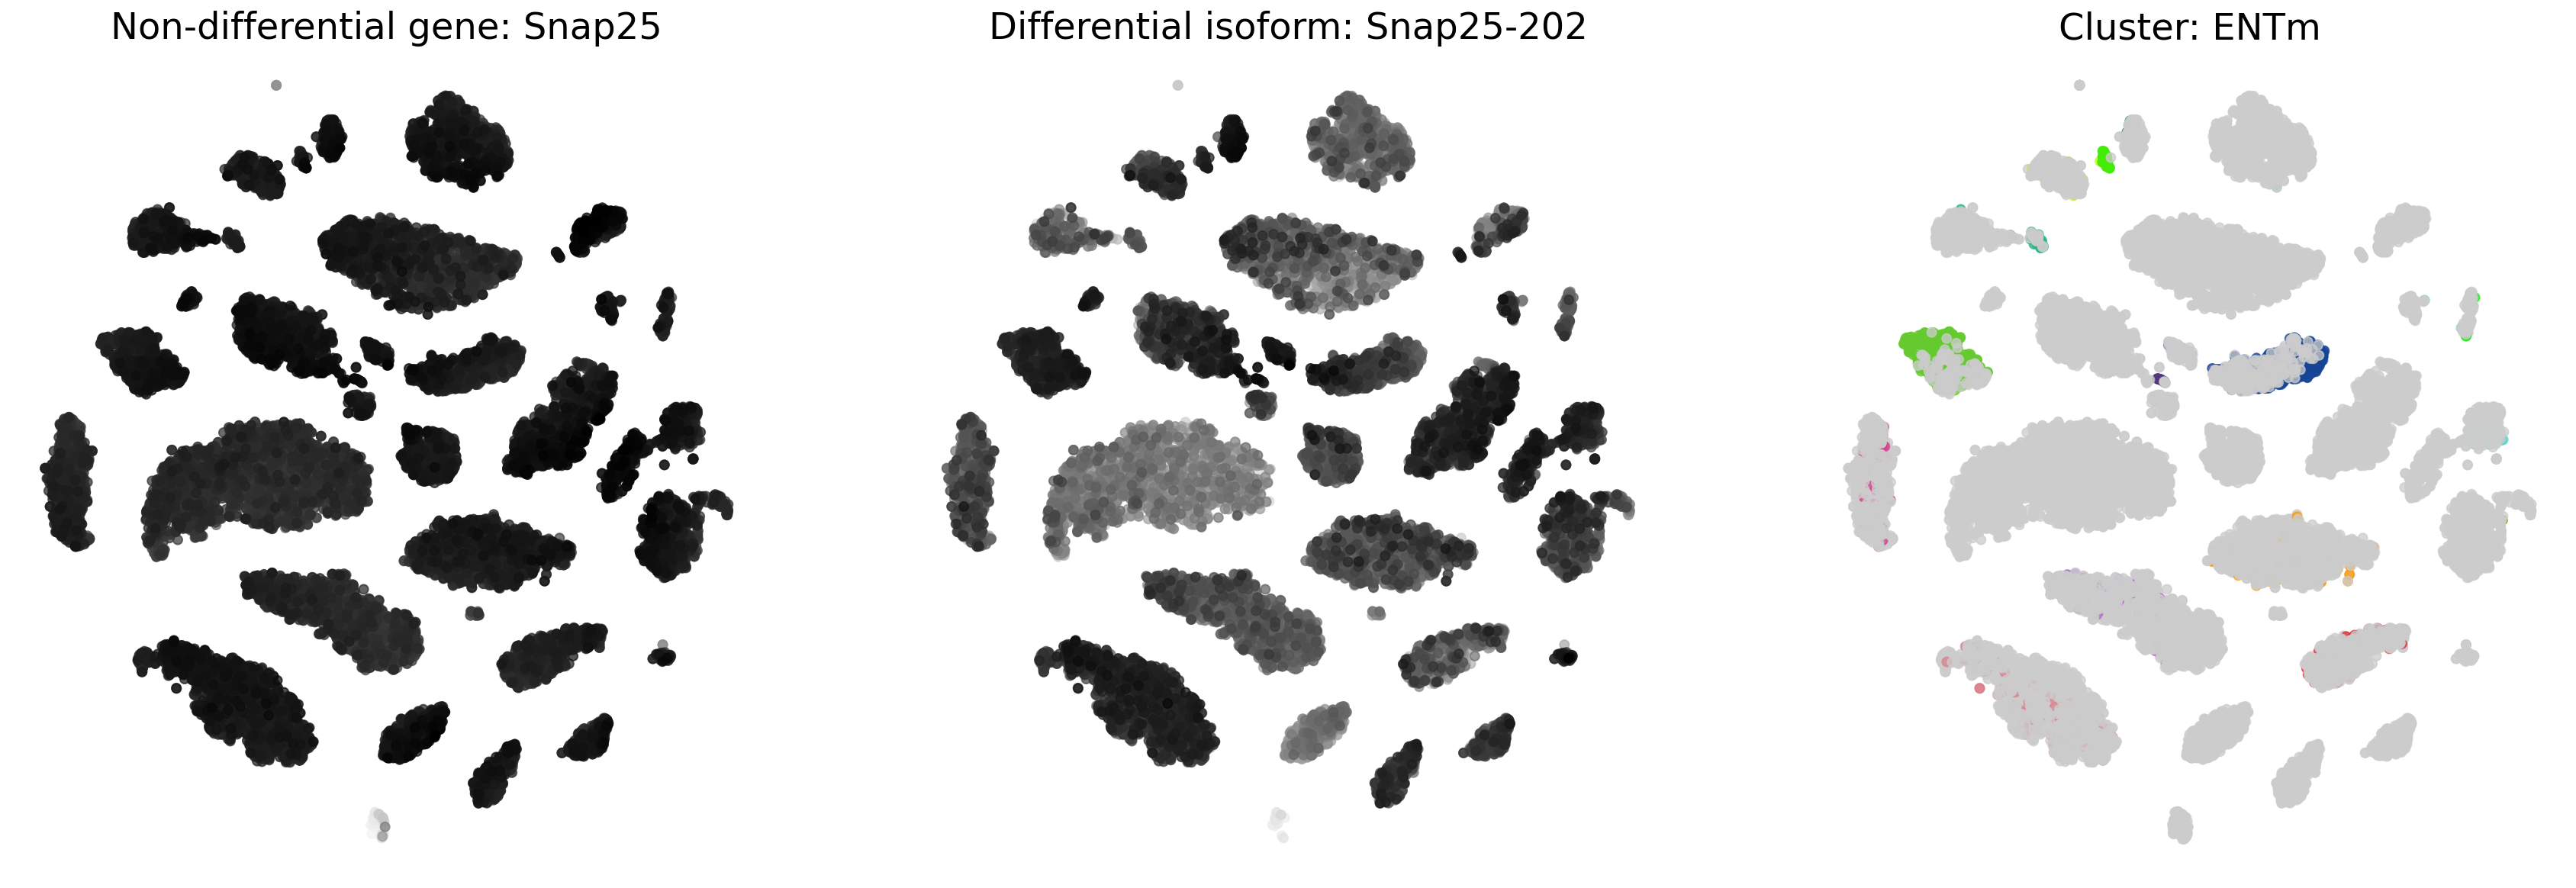

In [21]:
complement_color = (0.8, 0.8, 0.8, 1.0)

fig, ax = plt.subplots(figsize=(30,10), ncols=3)

x = gene.obsm["X_nca_tsne"][:,0]
y = gene.obsm["X_nca_tsne"][:,1]
c = np.asarray(gene[:, gene.var.gene_name==specific_gene].layers["log1p"].todense()).reshape(-1)
argsort = np.argsort(c)
x = x[argsort]
y = y[argsort]
c = c[argsort]
cmap="Greys"
alpha = 0.75
ax[0].set_title("Non-differential gene: {}".format(specific_gene.split("_")[0]))

ax[0].scatter(x, y, c=c, cmap=cmap, alpha=alpha)
ax[0].set_axis_off()


x = gene.obsm["X_nca_tsne"][:,0]
y = gene.obsm["X_nca_tsne"][:,1]
c = np.asarray(isoform[:, isoform.var.transcript_name==specific_isoform].layers["log1p"].todense()).reshape(-1)
argsort = np.argsort(c)
x = x[argsort]
y = y[argsort]
c = c[argsort]
cmap="Greys"
alpha = 0.75
ax[1].set_title("Differential isoform: {}".format(specific_isoform.split("_")[0]))

ax[1].scatter(x, y, c=c, cmap=cmap, alpha=alpha)
ax[1].set_axis_off()

x = gene.obsm["X_nca_tsne"][:,0]
y = gene.obsm["X_nca_tsne"][:,1]
c = gene.obs["subclass_label"]==specific_region
c = gene.obs["subclass_label"].astype(str).map(subclass_cmap).tolist()
indices = np.where(gene.obs["region_label"]!=specific_region)[0]
replacements=[complement_color]*len(indices)
for (index, replacement) in zip(indices, replacements):
    c[index] = replacement
alpha=0.75
cmap="nipy_spectral_r"

ax[2].scatter(x, y, c=c, cmap=cmap, alpha=alpha)
ax[2].set_axis_off()
ax[2].set_title("Cluster: {}".format(specific_region))
plt.savefig("../../figures/class_DE_nca.png", bbox_inches='tight',dpi=300)
plt.show()

In [22]:
identified_isoforms = markers_isoform["name"].explode().astype(str)

In [23]:
identified_genes = identified_isoforms.apply(lambda x: x.split("-")[0:-1][0])

In [24]:
print("{} isoforms from {} genes identified.".format(identified_isoforms.shape[0], identified_genes.nunique()))

734 isoforms from 511 genes identified.


In [25]:
markers_isoform.to_csv("../../tables/unordered/region_DE.csv")